# TensorFlow Hub - Exercises

Dataset:

- https://www.kaggle.com/datasets/slothkong/10-monkey-species

### Import the Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import tensorflow as tf

import tensorflow_hub as hub

import os
import random
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [19]:
!nvidia-smi

Tue Jul 19 04:54:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |    314MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Connect to Kaggle, Download and unzip the dataset

- Explore the data

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d slothkong/10-monkey-species

100% 545M/547M [00:17<00:00, 34.5MB/s]
100% 547M/547M [00:17<00:00, 32.9MB/s]


In [5]:
import zipfile

uz = zipfile.ZipFile('10-monkey-species.zip')
uz.extractall()
uz.close()

### Explore the Data

- How many categories?
- How many images per directory?
- What is the size of the images?

In [7]:
total = 0

for dirs, fols, files in os.walk('training/training'):
  print(f'{dirs}, {fols}, {len(files)}')
  if len(fols) < 1:
    total += len(files)

print(f'\nTotal Files: {total}')

training/training, ['n5', 'n2', 'n4', 'n3', 'n0', 'n1', 'n6', 'n7', 'n8', 'n9'], 0
training/training/n5, [], 113
training/training/n2, [], 110
training/training/n4, [], 105
training/training/n3, [], 122
training/training/n0, [], 105
training/training/n1, [], 111
training/training/n6, [], 106
training/training/n7, [], 114
training/training/n8, [], 106
training/training/n9, [], 106

Total Files: 1098


(585, 800, 3)


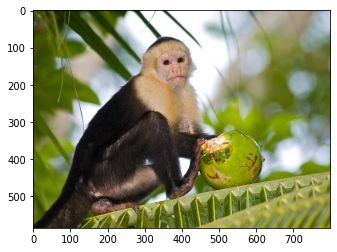

In [14]:
path = 'training/training/'
category = 'n5/'
target = path + category


image = random.choice(os.listdir(target))

# image

img = mpimage.imread(target + image)

print(img.shape)

plt.imshow(img)


### Batch and Normalize the Data

- Create ImageDataGenetor train_data_ff and test_ff batches
- Create image_dataset_from_directory train_img and test_img batches
- Get the class_names and create a dictionary

In [15]:
train_dir = 'training/training/'
test_dir = 'validation/validation/'





In [23]:
# Flow from directory with ImageDataGenerator

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_data_ff = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical'
)

test_data_ff = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='categorical'
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [25]:
# image_dataset_from_directory

train_data_img = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224,224),
    label_mode='categorical'
)

test_data_img = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    label_mode='categorical'
)

Found 1097 files belonging to 10 classes.
Found 272 files belonging to 10 classes.


### Model 1 - Create a Model with EfficientNetB0 - ff

- Setup the TFHub EfficientNetB0 Model
- Get a summary of the model
- Compile the model
- Fit the model on the train_data_ff for 5 epochs

In [24]:
model_1 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False,
                    dtype=tf.float32),  # Can be True, see below.

    tf.keras.layers.Dense(10, activation='softmax')
])
model_1.build([None, 224, 224, 3])  # Batch input shape.

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data_ff,
    validation_data=test_data_ff,
    epochs=5
)


Epoch 1/5
35/35 [==============================] - 54s 979ms/step - loss: 1.2553 - accuracy: 0.7459 - val_loss: 0.5310 - val_accuracy: 0.9743
Epoch 2/5
35/35 [==============================] - 31s 891ms/step - loss: 0.3024 - accuracy: 0.9818 - val_loss: 0.2204 - val_accuracy: 0.9963
Epoch 3/5
35/35 [==============================] - 30s 875ms/step - loss: 0.1510 - accuracy: 0.9927 - val_loss: 0.1441 - val_accuracy: 0.9963
Epoch 4/5
35/35 [==============================] - 30s 865ms/step - loss: 0.1012 - accuracy: 0.9954 - val_loss: 0.1091 - val_accuracy: 0.9963
Epoch 5/5
35/35 [==============================] - 30s 872ms/step - loss: 0.0754 - accuracy: 0.9954 - val_loss: 0.0881 - val_accuracy: 0.9963


In [22]:
m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Model 2 - Create a Model with EfficientNetB0 - img

- Setup the TFHub EfficientNetB0 Model
- Get a summary of the model
- Compile the model
- Fit the model on the train_data_img for 5 epochs

In [28]:
model_2 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False,
                   dtype=tf.float32),  # Can be True, see below.
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.build([None, 224, 224, 3])  # Batch input shape.

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
35/35 [==============================] - 25s 420ms/step - loss: 808.6732 - accuracy: 0.1048 - val_loss: 699.0883 - val_accuracy: 0.1029
Epoch 2/5
35/35 [==============================] - 15s 375ms/step - loss: 473.6192 - accuracy: 0.1459 - val_loss: 545.8088 - val_accuracy: 0.1250
Epoch 3/5
35/35 [==============================] - 15s 347ms/step - loss: 289.3724 - accuracy: 0.2051 - val_loss: 455.3603 - val_accuracy: 0.1140
Epoch 4/5
35/35 [==============================] - 14s 349ms/step - loss: 238.5154 - accuracy: 0.2224 - val_loss: 456.1618 - val_accuracy: 0.1434
Epoch 5/5
35/35 [==============================] - 15s 353ms/step - loss: 205.6931 - accuracy: 0.2434 - val_loss: 444.5294 - val_accuracy: 0.1581


In [27]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_4 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Model 3 - EfficientNet Add A Rescaling Layer

- Break out the KerasLayer and add it to the Sequential model
- Add a Rescaling Layer between the Sequential Layer and the KerasLayer
- Add a Fully connected Dense layer with 1000 units after the Keras Layer
- Create the output Layer
- Build the model and look at the summary
- Compile and Fit the model on the train_data_img for 5 epochs

In [31]:
model_3 = tf.keras.Sequential()

model_3.add(tf.keras.layers.Rescaling(scale=1./255))

model_3.add(hub.KerasLayer(
    "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
    trainable=False,
    dtype=tf.float32))

# model_3.add(tf.keras.layers.Dense(1000, activation='relu'))

model_3.add(tf.keras.layers.Dense(10, activation='softmax'))

model_3.build([None, 224, 224, 3])  # Batch input shape.

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
35/35 [==============================] - 25s 374ms/step - loss: 1.2272 - accuracy: 0.7903 - val_loss: 0.5118 - val_accuracy: 0.9779
Epoch 2/5
35/35 [==============================] - 15s 360ms/step - loss: 0.2863 - accuracy: 0.9836 - val_loss: 0.2162 - val_accuracy: 0.9926
Epoch 3/5
35/35 [==============================] - 14s 346ms/step - loss: 0.1432 - accuracy: 0.9900 - val_loss: 0.1412 - val_accuracy: 0.9963
Epoch 4/5
35/35 [==============================] - 14s 350ms/step - loss: 0.0958 - accuracy: 0.9927 - val_loss: 0.1065 - val_accuracy: 0.9963
Epoch 5/5
35/35 [==============================] - 15s 373ms/step - loss: 0.0707 - accuracy: 0.9964 - val_loss: 0.0868 - val_accuracy: 0.9963


In [30]:
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer_6 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_6 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Model 4 - Create a Model with ResNet50V2

- Setup the TFHub ResNet50V2 Model
- Break out the KerasLayer and add it to the Sequential model
- Add a Rescaling Layer between the Sequential Layer and the KerasLayer
- Add a Fully connected Dense layer with 1000 units after the Keras Layer
- Create the output Layer
- Build the model and look at the summary
- Compile and Fit the model on the train_data_img for 5 epochs

In [34]:
model_4 = tf.keras.Sequential()

model_4.add(tf.keras.layers.Rescaling(scale=1./255))

model_4.add(hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
    trainable=False,
    dtype=tf.float32))


model_4.add(tf.keras.layers.Dense(10, activation='softmax'))

model_4.build([None, 224, 224, 3])  # Batch input shape.

model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4 = model_4.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
35/35 [==============================] - 21s 410ms/step - loss: 0.9815 - accuracy: 0.7056 - val_loss: 0.2716 - val_accuracy: 0.9228
Epoch 2/5
35/35 [==============================] - 15s 360ms/step - loss: 0.1373 - accuracy: 0.9745 - val_loss: 0.1580 - val_accuracy: 0.9596
Epoch 3/5
35/35 [==============================] - 15s 361ms/step - loss: 0.0774 - accuracy: 0.9900 - val_loss: 0.1272 - val_accuracy: 0.9706
Epoch 4/5
35/35 [==============================] - 16s 399ms/step - loss: 0.0533 - accuracy: 0.9945 - val_loss: 0.1132 - val_accuracy: 0.9669
Epoch 5/5
35/35 [==============================] - 15s 367ms/step - loss: 0.0376 - accuracy: 0.9982 - val_loss: 0.0948 - val_accuracy: 0.9669


In [33]:
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_8 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_8 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Model 5 - Create a Model with InceptionResNetV2

- Setup the TFHub IncetpionsResNetV2 Model
- Break out the KerasLayer and add it to the Sequential model
- Add a Rescaling Layer between the Sequential Layer and the KerasLayer
- Add a Fully connected Dense layer with 1000 units after the Keras Layer
- Create the output Layer
- Build the model and look at the summary
- Compile and Fit the model on the train_data_img for 5 epochs

In [35]:
model_5 = tf.keras.Sequential()

model_5.add(tf.keras.layers.Rescaling(scale=1./255))


model_5.add(hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
    trainable=False,
    dtype=tf.float32))

model_5.add(tf.keras.layers.Dense(10, activation='softmax'))
model_5.build([None, 299, 299, 3])  # Batch input shape.

model_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5 = model_5.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
35/35 [==============================] - 37s 550ms/step - loss: 0.7401 - accuracy: 0.7830 - val_loss: 0.2232 - val_accuracy: 0.9522
Epoch 2/5
35/35 [==============================] - 17s 428ms/step - loss: 0.1596 - accuracy: 0.9581 - val_loss: 0.1354 - val_accuracy: 0.9706
Epoch 3/5
35/35 [==============================] - 18s 437ms/step - loss: 0.1054 - accuracy: 0.9790 - val_loss: 0.1168 - val_accuracy: 0.9743
Epoch 4/5
35/35 [==============================] - 18s 436ms/step - loss: 0.0783 - accuracy: 0.9845 - val_loss: 0.0935 - val_accuracy: 0.9816
Epoch 5/5
35/35 [==============================] - 18s 435ms/step - loss: 0.0653 - accuracy: 0.9845 - val_loss: 0.0844 - val_accuracy: 0.9853


In [36]:
model_5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 keras_layer_10 (KerasLayer)  (None, 1536)             54336736  
                                                                 
 dense_10 (Dense)            (None, 10)                15370     
                                                                 
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


### Run predictions on Model (your choice)

[5]


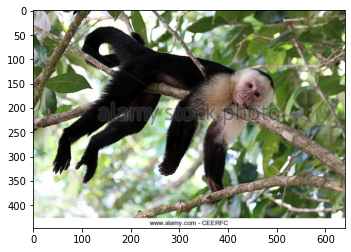

In [54]:
path = 'validation/validation/'
category = 'n5/'
target = path + category


image = random.choice(os.listdir(target))



# Run our prediction
img = tf.io.read_file(target+image)
img = tf.io.decode_image(img)
img = tf.image.resize(img, [224,224])
img = img/255.
img = tf.expand_dims(img, axis=0)

pred = np.argmax(model_1.predict(img), axis=1)

print(pred)

img_plot = mpimage.imread(target + image)

# print(img_plot.shape)

plt.imshow(img_plot)

In [37]:
test_data_img.class_names

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [38]:
test_data_ff.class_indices

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [39]:
class_names = dict(zip(
    test_data_img.class_names,
    np.arange(len(test_data_img.class_names))
))

In [40]:
class_names

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [59]:
y_true = []
predictions = []

def predictor(path, image):
  category = path.split('/')[2]
  target = path + '/' + image
  

  # Run our prediction
  img = tf.io.read_file(target)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [224,224])
  img = img/255.
  img = tf.expand_dims(img, axis=0)

  pred = np.argmax(model_1.predict(img), axis=1)

  predictions.append(pred[0])

  y_true.append(class_names[category])

In [60]:
for dirs, fols, files in os.walk('validation/validation'):
  print(f'{dirs}, {fols}, {len(files)}')
  if len(fols) < 1:
    for file in files:
      predictor(dirs, file)

validation/validation, ['n5', 'n2', 'n4', 'n3', 'n0', 'n1', 'n6', 'n7', 'n8', 'n9'], 0
validation/validation/n5, [], 28
validation/validation/n2, [], 27
validation/validation/n4, [], 26
validation/validation/n3, [], 30
validation/validation/n0, [], 26
validation/validation/n1, [], 28
validation/validation/n6, [], 26
validation/validation/n7, [], 28
validation/validation/n8, [], 27
validation/validation/n9, [], 26


In [61]:
len(y_true) == len(predictions)

True

In [62]:
set(y_true) == set(predictions)

True

In [63]:
import seaborn as sns

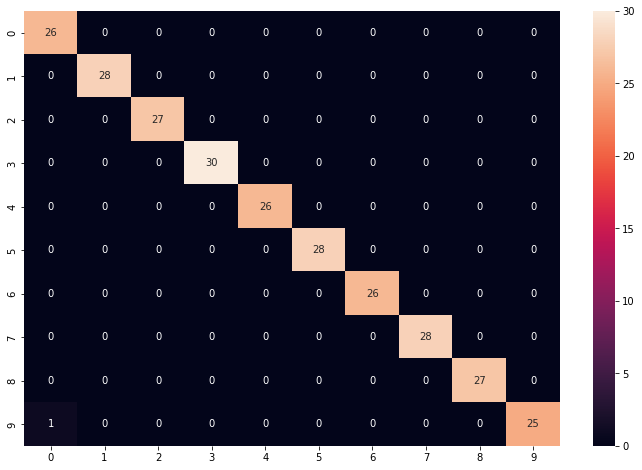

In [64]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_true, predictions), annot=True)

In [65]:
confusion_matrix(y_true, predictions)

array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 26,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 27,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0, 25]])

In [66]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        27
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        28
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        27
           9       1.00      0.96      0.98        26

    accuracy                           1.00       272
   macro avg       1.00      1.00      1.00       272
weighted avg       1.00      1.00      1.00       272

